# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [3]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader


In [4]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

100%|██████████| 170498071/170498071 [00:10<00:00, 16139872.12it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

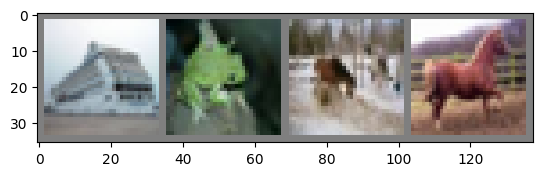

ship frog horse horse


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=32),
        )
        self.added_lay = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        self.pooling = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8)
        )
        self.linear = nn.Linear(in_features=512, out_features=n_classes)

    def forward(self, x):
        out = self.pooling(self.encoder(x) + self.added_lay(x))
        out = self.linear(out.reshape((-1, 512)))
        return out

In [ ]:
net = BasicBlockNet()
net

BasicBlockNet(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (added_lay): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (pooling): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [ ]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

где искал код - https://github.com/isadrtdinov/intro-to-dl-hse/blob/2023-2024/seminars/211/Seminar_2_DL_1.ipynb

In [7]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    loss_func = nn.CrossEntropyLoss()

    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            out = model(data)
        loss = loss_func(out, target)

        loss_log.append(loss.item())

        pred = torch.argmax(out, dim=1)
        acc_log.append((pred == target).detach().cpu().numpy().sum() / len(pred))

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    loss_func = nn.CrossEntropyLoss()

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        out = model(data)
        loss = loss_func(out, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        # я в самом начале хотел использовать accuracy_score, но она просит все перекинуть на cpu:( поэтому просто векторные вычисления
        pred = torch.argmax(out, dim=1)
        acc_log.append((pred == target).detach().cpu().numpy().sum() / len(pred))

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0

 train loss: 1.4560255718841413, train acc: 0.48086967876730213

 val loss: 1.1957616511811602, val acc: 0.575



Epoch 1

 train loss: 1.149464354981452, train acc: 0.5979367981196134

 val loss: 1.1335095664288135, val acc: 0.6101063829787234



Epoch 2

 train loss: 1.0363515109858958, train acc: 0.6366340754766258

 val loss: 1.096979467158622, val acc: 0.6218528368794327



Epoch 3

 train loss: 0.9859169225806074, train acc: 0.6560337229041525

 val loss: 1.0458332383886297, val acc: 0.6417553191489361



Epoch 4

 train loss: 0.9496493606506362, train acc: 0.6710874249151215

 val loss: 0.9823558924045969, val acc: 0.660438829787234



Epoch 5

 train loss: 0.9246000066753716, train acc: 0.6791712914599113

 val loss: 0.9526462382458626, val acc: 0.6743351063829788



Epoch 6

 train loss: 0.9014016755974052, train acc: 0.6863410812222512

 val loss: 1.0600254180583548, val acc: 0.6405806737588652



Epoch 7

 train loss: 0.882988892155112, train acc: 0.6946085792635154

Посчитайте точность на тестовой выборке:

In [ ]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(0.8811675355692578, 0.6986464968152867)

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

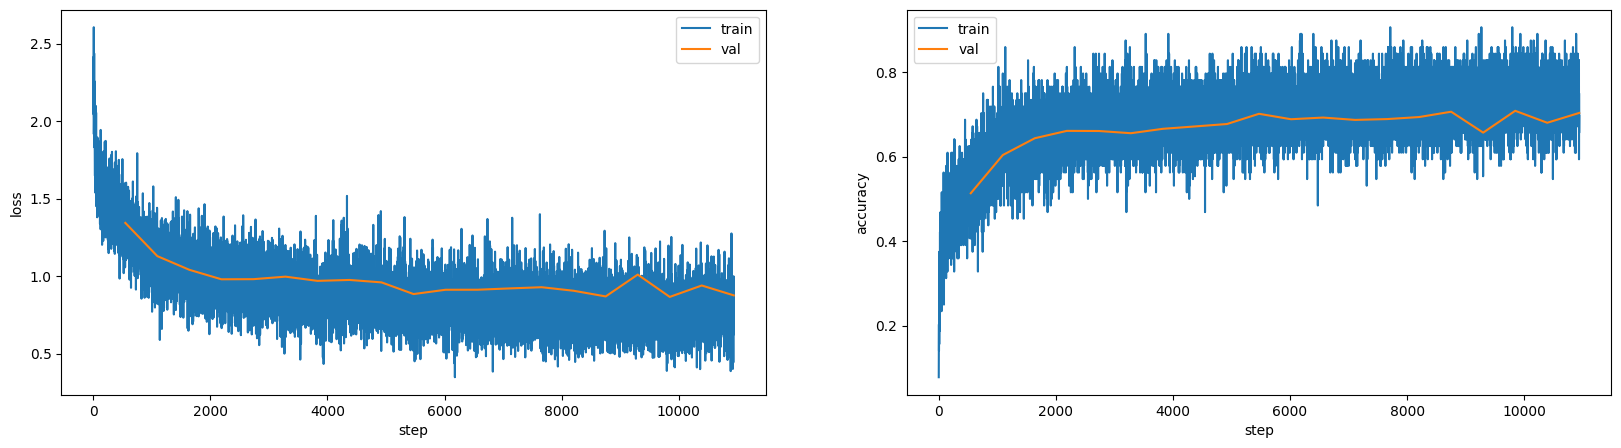

In [ ]:
epochs = 20

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(np.linspace(0, len(train_loss_log), len(train_loss_log), dtype='int'), train_loss_log, label='train')
axs[0].plot(np.linspace(len(train_loss_log) / epochs, len(train_loss_log), epochs, dtype='int'), val_loss_log, label='val')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('step')
axs[0].legend()

axs[1].plot(np.linspace(0, len(train_acc_log), len(train_acc_log), dtype='int'), train_acc_log, label='train')
axs[1].plot(np.linspace(len(train_acc_log) / epochs, len(train_acc_log), epochs, dtype='int'), val_acc_log, label='val')
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('step')
axs[1].legend()

plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0

 train loss: 1.4689050468273965, train acc: 0.4767930595455732

 val loss: 1.2993434687878223, val acc: 0.5386524822695036



Epoch 1

 train loss: 1.1557415971154488, train acc: 0.5949456450770437

 val loss: 1.1263782214611135, val acc: 0.6056737588652481



Epoch 2

 train loss: 1.052147770494604, train acc: 0.6335980347349177

 val loss: 1.2227821928389528, val acc: 0.5790558510638298



Epoch 3

 train loss: 0.990723845509768, train acc: 0.6547034147296945

 val loss: 0.9983465179483941, val acc: 0.6586436170212766



Epoch 4

 train loss: 0.9492899065043852, train acc: 0.668989945155393

 val loss: 1.0052682863905076, val acc: 0.6488031914893617



Epoch 5

 train loss: 0.9167562747132407, train acc: 0.6811626730216767

 val loss: 0.9887010259831205, val acc: 0.6629432624113476



Epoch 6

 train loss: 0.9004104070951123, train acc: 0.6851944045442674

 val loss: 0.9146017551422119, val acc: 0.6881870567375886



Epoch 7

 train loss: 0.882208693071083, train acc: 0.6926

Посчитайте точность на тестовой выборке:

In [ ]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(0.8197700929869512, 0.7166600318471338)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0

 train loss: 1.8587570839869694, train acc: 0.3467207495429616

 val loss: 1.6385131653319014, val acc: 0.431781914893617



Epoch 1

 train loss: 1.5726077683011181, train acc: 0.44772215330373466

 val loss: 1.4885328926938646, val acc: 0.4777482269503546



Epoch 2

 train loss: 1.4449384931672427, train acc: 0.49235276834682684

 val loss: 1.4082004328991504, val acc: 0.50489804964539



Epoch 3

 train loss: 1.360844327283298, train acc: 0.5225744319665709

 val loss: 1.3148669293586244, val acc: 0.540270390070922



Epoch 4

 train loss: 1.2996003714950255, train acc: 0.5455691760250718

 val loss: 1.2576116683635306, val acc: 0.5645168439716312



Epoch 5

 train loss: 1.245707013925207, train acc: 0.563503852180726

 val loss: 1.2151634982291688, val acc: 0.578235815602837



Epoch 6

 train loss: 1.2047302315396409, train acc: 0.5816711282319142

 val loss: 1.2025297918218247, val acc: 0.5808289007092199



Epoch 7

 train loss: 1.160372553294494, train acc: 0.5957291

In [ ]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(0.9371924647100413, 0.6751592356687898)

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

1 - LambdaLR (https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html#torch.optim.lr_scheduler.LambdaLR)

Устанавливает текущий lr каждой группы параметров как начальное значение lr, умноженное на заданную функцию ламбда. Когда идет последняя эпоха, устанавливает начальный lr как lr текущий.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# код взят с сайта доки
lambda1 = lambda epoch: 1 / (epoch + 1)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0

 train loss: 1.8411738717795727, train acc: 0.3583915513188822

 val loss: 1.6209714843871745, val acc: 0.4365026595744681



Epoch 1

 train loss: 1.5820379586280808, train acc: 0.4489953316792897

 val loss: 1.52359749915752, val acc: 0.4656914893617021



Epoch 2

 train loss: 1.509782007668964, train acc: 0.47126371115173676

 val loss: 1.4770095972304649, val acc: 0.4842198581560283



Epoch 3

 train loss: 1.4691194461512174, train acc: 0.48583589057195087

 val loss: 1.4482595600980392, val acc: 0.49288563829787235



Epoch 4

 train loss: 1.4405358933879426, train acc: 0.49513580569339255

 val loss: 1.422764616824211, val acc: 0.49818262411347514



Epoch 5

 train loss: 1.422232287021616, train acc: 0.5020444306607469

 val loss: 1.406478270064009, val acc: 0.5073359929078015



Epoch 6

 train loss: 1.4069537325358696, train acc: 0.5079655262470619

 val loss: 1.3925412127312193, val acc: 0.5104831560283688



Epoch 7

 train loss: 1.3941308323164527, train acc: 0.5

In [ ]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(1.3145370976940083, 0.5428941082802548)

2 - CyclicLR (https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CyclicLR.html#torch.optim.lr_scheduler.CyclicLR)

Устанавливает lr каждой группы параметров в соответствии с cyclical learning rate policy (CLR) - наши lr перебираются не линейно монотонно, а циклически в пределах разумных значений

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# код взят с сайта доки
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0

 train loss: 1.5031235475208904, train acc: 0.4615271611386785

 val loss: 1.3179775258328053, val acc: 0.5243129432624114



Epoch 1

 train loss: 1.228375538611543, train acc: 0.5641077957691303

 val loss: 1.179138656879993, val acc: 0.5869459219858156



Epoch 2

 train loss: 1.1024655907855827, train acc: 0.6133496017236876

 val loss: 1.1117187431518067, val acc: 0.6087765957446809



Epoch 3

 train loss: 1.0263687500788046, train acc: 0.6425633324627841

 val loss: 1.059683607994242, val acc: 0.6351728723404255



Epoch 4

 train loss: 0.9788973091725239, train acc: 0.6582454622616872

 val loss: 0.9649532016287459, val acc: 0.6640514184397163



Epoch 5

 train loss: 0.9423850943663002, train acc: 0.67105886001567

 val loss: 0.9845958192297752, val acc: 0.6574468085106383



Epoch 6

 train loss: 0.9126633296718981, train acc: 0.6834805105771742

 val loss: 0.9101281287822317, val acc: 0.6880984042553191



Epoch 7

 train loss: 0.8929363038029924, train acc: 0.69137

In [ ]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(0.8240290413236921, 0.7202428343949044)

3 - PolynomialLR (https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.PolynomialLR.html#torch.optim.lr_scheduler.PolynomialLR)

Разложение lr с помощью полиномиальной функции в заданных total_iters. Когда epochs >= total_iters, lr = 0

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# код взят с сайта доки
scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=15, power=1.0)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0

 train loss: 1.7925140872951835, train acc: 0.37805236354139465

 val loss: 1.5709551045235166, val acc: 0.4509973404255319



Epoch 1

 train loss: 1.4971763444774984, train acc: 0.4754505092713502

 val loss: 1.4250074203978194, val acc: 0.4954565602836879



Epoch 2

 train loss: 1.3901622803163267, train acc: 0.5135316009401932

 val loss: 1.359957888785829, val acc: 0.5218085106382979



Epoch 3

 train loss: 1.3256026733074153, train acc: 0.5391583964481589

 val loss: 1.3469149685920554, val acc: 0.5166666666666666



Epoch 4

 train loss: 1.279017751352007, train acc: 0.5564483220161922

 val loss: 1.2631245889562241, val acc: 0.557845744680851



Epoch 5

 train loss: 1.2425163777262462, train acc: 0.5687271480804388

 val loss: 1.2376658944373435, val acc: 0.5663342198581561



Epoch 6

 train loss: 1.214881738535447, train acc: 0.5767171585270305

 val loss: 1.1951048346275979, val acc: 0.5809840425531915



Epoch 7

 train loss: 1.1910777810068844, train acc: 0.586

In [ ]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(1.0988827624898048, 0.6183320063694268)

**Your answers here:** что-то на первом шудулере у нас получилась просто ужасная ошибка, на третьем у нас ошибка тоже стала хуже (но не так сильно), а вот на втором получилась намного лучше, чем была до этого (ну в описании этого метода, что он намного круче обычного перебора lr)

## 4. Аугментации данных (2 балла)

> Блок с отступами



Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

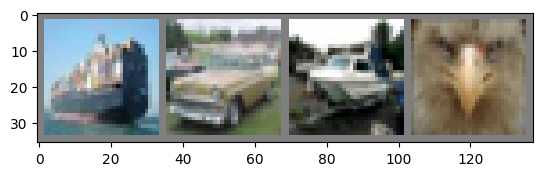

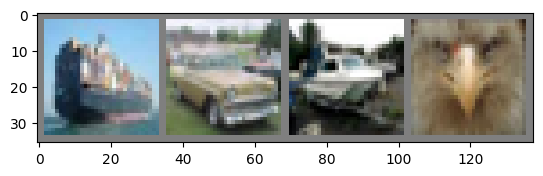

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified

Files already downloaded and verified

Epoch 0

 train loss: 1.4860800981957472, train acc: 0.46904381039435883

 val loss: 1.2978328101178433, val acc: 0.535549645390071



Epoch 1

 train loss: 1.187185336837385, train acc: 0.5819935035257248

 val loss: 1.12901054367106, val acc: 0.6066489361702128



Epoch 2

 train loss: 1.0568751479197682, train acc: 0.6291255876207887

 val loss: 1.0625036277669542, val acc: 0.6310726950354609



Epoch 3

 train loss: 0.9958087638483623, train acc: 0.6536057064507704

 val loss: 0.9921102599894747, val acc: 0.6647606382978724



Epoch 4

 train loss: 0.9572881882979621, train acc: 0.6679616087751371

 val loss: 0.9997181258303054, val acc: 0.6513297872340426



Epoch 5

 train loss: 0.9190906641470231, train acc: 0.6783918777748759

 val loss: 0.9455098238397152, val acc: 0.6659131205673758



Epoch 6

 train loss: 0.9033821124917193, train acc: 0.6888629537738313

 val loss: 0.948144912212453, val acc: 0.6

Посчитайте точность на тестовой выборке:

In [ ]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(0.7940021848223012, 0.7264132165605095)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

1 - RandomGrayscale\

С вероятностью 0.1 преобразует наше изображение в то же изображение, но в серых тонах

In [ ]:
transform = transforms.Compose(
        [torchvision.transforms.RandomGrayscale(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified

Files already downloaded and verified

Epoch 0

 train loss: 1.5086714265769317, train acc: 0.4628697114129015

 val loss: 1.2821880934086252, val acc: 0.5419326241134752



Epoch 1

 train loss: 1.2031369873984858, train acc: 0.582585205014364

 val loss: 1.136110157154976, val acc: 0.6093085106382978



Epoch 2

 train loss: 1.074187765173764, train acc: 0.6267506202663881

 val loss: 1.0706718533597095, val acc: 0.634020390070922



Epoch 3

 train loss: 1.007898862117823, train acc: 0.6484028140506659

 val loss: 0.9932756170313409, val acc: 0.6593528368794327



Epoch 4

 train loss: 0.9593294453577325, train acc: 0.6675249738835205

 val loss: 1.0086365917895703, val acc: 0.6481161347517731



Epoch 5

 train loss: 0.930145138469431, train acc: 0.6770860537999478

 val loss: 1.0441784148520612, val acc: 0.6290558510638298



Epoch 6

 train loss: 0.9040165376837555, train acc: 0.6843986680595456

 val loss: 0.9720116711677389, val acc: 0.662

In [ ]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(0.797115415714349, 0.7267117834394905)

2 - RandomRotation

Крутит наше изображение на некий градус

In [ ]:
transform = transforms.Compose(
        [torchvision.transforms.RandomRotation(degrees=45), # == (-45, 45) показания будут
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified

Files already downloaded and verified

Epoch 0

 train loss: 1.6673167974465073, train acc: 0.400422760511883

 val loss: 1.5160997715402156, val acc: 0.45463209219858153



Epoch 1

 train loss: 1.4566941141428416, train acc: 0.483709845912771

 val loss: 1.4231168620129848, val acc: 0.4949468085106383



Epoch 2

 train loss: 1.3681176399618007, train acc: 0.5162248628884827

 val loss: 1.348656464637594, val acc: 0.5225620567375886



Epoch 3

 train loss: 1.3180436336144232, train acc: 0.5324782906764168

 val loss: 1.2777824860938052, val acc: 0.546697695035461



Epoch 4

 train loss: 1.2724713470643791, train acc: 0.5519269065030035

 val loss: 1.2323379569865287, val acc: 0.5650709219858157



Epoch 5

 train loss: 1.2429875084207525, train acc: 0.5602678571428572

 val loss: 1.2725436897988016, val acc: 0.5511081560283688



Epoch 6

 train loss: 1.2135531048016313, train acc: 0.5691311373726821

 val loss: 1.1893687963485717, val acc: 0.

In [ ]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(0.9489198334657463, 0.6722730891719745)

3 - RandomPerspective

C вероятностью 0.5 применяет перспектиное преобразование в 0.5 раз на изображении

In [ ]:
transform = transforms.Compose(
        [torchvision.transforms.RandomPerspective(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified

Files already downloaded and verified

Epoch 0

 train loss: 1.6993870530311543, train acc: 0.3810353551841212

 val loss: 1.5371795852133567, val acc: 0.4387632978723404



Epoch 1

 train loss: 1.4661753746447659, train acc: 0.4711780164533821

 val loss: 1.3574287612387474, val acc: 0.5219636524822695



Epoch 2

 train loss: 1.3223541455251426, train acc: 0.5270876860799164

 val loss: 1.259781413889946, val acc: 0.5572030141843971



Epoch 3

 train loss: 1.2407025868103752, train acc: 0.5608677200313399

 val loss: 1.225190240271548, val acc: 0.5717863475177306



Epoch 4

 train loss: 1.190072018986864, train acc: 0.5797817641681902

 val loss: 1.3733251843046634, val acc: 0.5290336879432624



Epoch 5

 train loss: 1.1618347993934395, train acc: 0.5934888352050144

 val loss: 1.1594681143760681, val acc: 0.5873226950354609



Epoch 6

 train loss: 1.1295878195239595, train acc: 0.6060981979629145

 val loss: 1.1540533167250613, val acc: 0.

In [ ]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(0.8641270144729857, 0.7028264331210191)

Все вместе:

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         torchvision.transforms.RandomGrayscale(),
         torchvision.transforms.RandomPerspective(),
         torchvision.transforms.RandomRotation(degrees=45),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified

Files already downloaded and verified

Epoch 0

 train loss: 1.8322078724012079, train acc: 0.3351927722642988

 val loss: 1.70616718758928, val acc: 0.37109929078014187



Epoch 1

 train loss: 1.6688760636711468, train acc: 0.40225091407678243

 val loss: 1.6362856169964404, val acc: 0.414915780141844



Epoch 2

 train loss: 1.5934474073772675, train acc: 0.42693098720292505

 val loss: 1.53209799604213, val acc: 0.45237145390070915



Epoch 3

 train loss: 1.542970333282429, train acc: 0.4435639200835727

 val loss: 1.520774894572319, val acc: 0.454188829787234



Epoch 4

 train loss: 1.4971290979350507, train acc: 0.4622943327239488

 val loss: 1.4800019198275627, val acc: 0.47265070921985813



Epoch 5

 train loss: 1.4593238157153783, train acc: 0.47869058500914075

 val loss: 1.4354846183289873, val acc: 0.4954343971631206



Epoch 6

 train loss: 1.4418941206644396, train acc: 0.48646023765996343

 val loss: 1.4529639994844477, val acc: 

In [ ]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(1.035155447045709, 0.6404259554140127)

**Your answers here:**

Горизонтальное преобр - 0.7264132165605095\
Серый цвет - 0.7267117834394905\
Прокурутка изображения - 0.6722730891719745\
Перспектива - 0.7028264331210191\
**Вместе - 0.6404259554140127**\
Вывод: Безусловно аугментация данных помогает нам лучше обучить модель, так как трактор (условно) во всех тонах и поворотах должен распозноваться трактором, а наша модель до этого не умела так думать (то есть в ее понимании тот же трактор может смотреть только направо и должен быть цветным, а когда получала серый трактор, смотрящий налево, офигевала и выдавала дичь, а не ответ).

Что же касается самих преобразований: горизонт, серый цвет показали себя хорошо отдельно, а вот поворот изображения что-то оказался слишком плох и портил всю малину. Перспектива - тоже на любителя, я бы в будущем (если надо было бы в продолжении просто сделать наилучшую модель) не использовал бы. В совокупности наши преобразования дали хуже ошибку (намного хуже), смею предположить, что это из-за прокрутки изображений (да просто каша из них получилась, надо будет использовать метод (забыл название), который рандомно из них выбирает трансформер)

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [8]:
!pip3 install wandb

In [9]:
import wandb

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    train_len_epoch_loss = []
    train_len_epoch_acc = []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        train_len_epoch_loss.append(len(train_loss_log))
        train_len_epoch_acc.append(len(train_acc_log))

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)
        
        run_train = wandb.init(project='deep_learning_hw2', name="train data", resume=(epoch>0), reinit=True)
        data = [[x, y] for (x, y) in zip(np.linspace(0, len(train_loss_log), len(train_loss_log), dtype='int'), train_loss_log)]
        table = wandb.Table(data=data, columns = ["step", "data"])
        run_train.log({"loss" : wandb.plot.line(table, "step",
                  "data", stroke=None, title="loss")})
        
        data = [[x, y] for (x, y) in zip(np.linspace(0, len(train_acc_log), len(train_acc_log), dtype='int'), train_acc_log)]
        table = wandb.Table(data=data, columns = ["step", "data"])
        run_train.log({"accuracy" : wandb.plot.line(table, "step",
                  "data", stroke=None, title="accuracy")})
#         run_train.finish()
        
        run_val = wandb.init(project='deep_learning_hw2', name="val data", resume=(epoch>0), reinit=True)
        data = [[x, y] for (x, y) in zip(np.linspace(len(train_loss_log) / (epoch + 1), len(train_loss_log), epoch + 1, dtype='int'), val_loss_log)]
        table = wandb.Table(data=data, columns = ["step", "data"])
        run_val.log({"loss" : wandb.plot.line(table, "step",
                  "data", stroke=None, title="loss")})

        data = [[x, y] for (x, y) in zip(np.linspace(len(train_acc_log) / (epoch + 1), len(train_acc_log), epoch + 1, dtype='int'), val_acc_log)]
        table = wandb.Table(data=data, columns = ["step", "data"])
        run_val.log({"accuracy" : wandb.plot.line(table, "step",
                  "data", stroke=None, title="accuracy")})
#         run_val.finish()

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

#     # train
#     run_train = wandb.init(project='deep_learning_hw2', name="train data", reinit=True)
#     for epoch in range(n_epochs):
#         data = [[x, y] for (x, y) in zip(np.linspace(0, train_len_epoch_loss[epoch], train_len_epoch_loss[epoch], dtype='int'), train_loss_log[:train_len_epoch_loss[epoch]])]
#         table = wandb.Table(data=data, columns = ["step", "data"])
#         run_train.log({"loss" : wandb.plot.line(table, "step",
#                   "data", stroke=None, title="loss")})
        
#         data = [[x, y] for (x, y) in zip(np.linspace(0, train_len_epoch_acc[epoch], train_len_epoch_acc[epoch], dtype='int'), train_acc_log[:train_len_epoch_acc[epoch]])]
#         table = wandb.Table(data=data, columns = ["step", "data"])
#         run_train.log({"accuracy" : wandb.plot.line(table, "step",
#                   "data", stroke=None, title="accuracy")})
#     run_train.finish()

#     # val
#     run_val = wandb.init(project='deep_learning_hw2', name="val data", reinit=True)
#     for epoch in range(n_epochs):
#         data = [[x, y] for (x, y) in zip(np.linspace(train_len_epoch_loss[epoch] / (epoch + 1), train_len_epoch_loss[epoch], epoch + 1, dtype='int'), val_loss_log[:(epoch+1)])]
#         table = wandb.Table(data=data, columns = ["step", "data"])
#         run_val.log({"loss" : wandb.plot.line(table, "step",
#                   "data", stroke=None, title="loss")})

#         data = [[x, y] for (x, y) in zip(np.linspace(train_len_epoch_acc[epoch] / (epoch + 1), train_len_epoch_acc[epoch], epoch + 1, dtype='int'), val_acc_log[:(epoch+1)])]
#         table = wandb.Table(data=data, columns = ["step", "data"])
#         run_val.log({"accuracy" : wandb.plot.line(table, "step",
#                   "data", stroke=None, title="accuracy")})
#     run_val.finish()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [ ]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

In [10]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 0
 train loss: 1.4951077056759237, train acc: 0.46728094802820574
 val loss: 1.293193476250831, val acc: 0.5331338652482269



Epoch 1
 train loss: 1.178549742349977, train acc: 0.5870086837294333
 val loss: 1.0720813809557164, val acc: 0.6242907801418439



Epoch 2
 train loss: 1.0498977635852598, train acc: 0.6358628231914338
 val loss: 1.0588956039002602, val acc: 0.6398714539007093



Epoch 3
 train loss: 0.985169184491229, train acc: 0.6567845716897363
 val loss: 0.9785668903208794, val acc: 0.6589317375886524



Epoch 4
 train loss: 0.944308423037067, train acc: 0.6704508357273439
 val loss: 1.0205429995313604, val acc: 0.6436835106382979



Epoch 5
 train loss: 0.910411091347717, train acc: 0.6844313136589187
 val loss: 0.9784471182112998, val acc: 0.6599734042553191



Epoch 6
 train loss: 0.891938387693827, train acc: 0.6893444763645861
 val loss: 1.0207191528157984, val acc: 0.6408466312056736



Epoch 7
 train loss: 0.8759641876168399, train acc: 0.6952492491512144
 val loss: 0.9257140479189284, val acc: 0.6842420212765957



Epoch 8
 train loss: 0.8614279037201862, train acc: 0.7014927200313399
 val loss: 0.93728537660964, val acc: 0.6819148936170213



Epoch 9
 train loss: 0.8350069912957535, train acc: 0.7080218399059807
 val loss: 0.8942494022085311, val acc: 0.6978723404255319



Epoch 10
 train loss: 0.8247730654053104, train acc: 0.7123106555236354
 val loss: 0.9401488413202002, val acc: 0.6787455673758864



Epoch 11
 train loss: 0.8126318185595315, train acc: 0.7173135936275791
 val loss: 0.8939647968779219, val acc: 0.6939051418439716



Epoch 12
 train loss: 0.7975517747280149, train acc: 0.7234468856098198
 val loss: 0.9008484012268959, val acc: 0.6918882978723404



Epoch 13
 train loss: 0.7907417717319956, train acc: 0.7265237333507443
 val loss: 0.9021198031750132, val acc: 0.6945700354609928



Epoch 14
 train loss: 0.7827734800644723, train acc: 0.7290986550013058
 val loss: 0.8578578817083481, val acc: 0.7052304964539008



Epoch 15
 train loss: 0.7718595388929412, train acc: 0.7334241969182554
 val loss: 0.8567527801432508, val acc: 0.7070700354609928



Epoch 16
 train loss: 0.7649465550888173, train acc: 0.7354400626795508
 val loss: 0.97837030710058, val acc: 0.6666223404255319



Epoch 17
 train loss: 0.7531864085188732, train acc: 0.7384230543222774
 val loss: 0.865901524969872, val acc: 0.7095079787234042



Epoch 18
 train loss: 0.7480755908179763, train acc: 0.7414223687646906
 val loss: 0.8715662910583172, val acc: 0.7013741134751774



Epoch 19
 train loss: 0.7432778510358695, train acc: 0.7418100352572473
 val loss: 0.8725722855709969, val acc: 0.7043218085106383



In [ ]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(0.8906409254499302, 0.697452229299363)

для решения использовал вот это: https://docs.wandb.ai/guides/track/log/plots (да и прочие ссылки, кучу всего перебрал для этой фигни)

а вот здесь мои графики (честно - уродский сайт, из-за которого иногда надо было перезапускать всю сессию в ноутбуке): https://wandb.ai/rodion-chernomordin/deep_learning_hw2/workspace?workspace=user-rodion-chernomordin